In [1]:
# ==================== VAE for DDoS Synthetic Data =====================
# Generates synthetic tabular data from your selected features
# Compatible with your existing ddos.csv setup (same preprocessing)

!pip install -q pandas scikit-learn torch matplotlib

import os, time, pathlib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import shutil
from google.colab import drive
drive.mount("/content/gdrive")
# Change the code below if the path to the dataset is different for you.
shutil.unpack_archive("/content/gdrive/MyDrive/ddos_dataset.zip", "/tmp/")

Mounted at /content/gdrive


In [3]:
# 1) CSV yükle (yolunu değiştir)
CSV_PATH = r"/tmp/dataset_sdn.csv"   # kendi dosya yolunu yaz
df = pd.read_csv(CSV_PATH, low_memory=False)
print(df.shape)
display(df.head())

(104345, 23)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [4]:

# ---------------- CONFIG ----------------

SELECTED_FEATURES = [
    'dt','pktcount','bytecount','dur','tot_dur',
    'packetins','pktperflow','byteperflow','pktrate','tx_bytes'
]
TARGET_COL = None
MODEL_DIR = "/content/drive/MyDrive/vae_ddos_checkpoints"
EPOCHS = 100
BATCH_SIZE = 128
LR = 1e-3
LATENT_DIM = 64
HIDDEN_DIM = 128
SEED = 42

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ========== Load and preprocess ==========
df = pd.read_csv(CSV_PATH, low_memory=False)
if TARGET_COL is None:
    for cand in ['label','Label','class','Class','attack','Attack','target','Target','flow_label']:
        if cand in df.columns:
            TARGET_COL = cand
            break
    if TARGET_COL is None:
        TARGET_COL = df.columns[-1]
print("Using target column:", TARGET_COL)

use_cols = [c for c in SELECTED_FEATURES if c in df.columns] + [TARGET_COL]
df_sel = df[use_cols].dropna().reset_index(drop=True)

if df_sel[TARGET_COL].dtype != int:
    df_sel[TARGET_COL] = pd.factorize(df_sel[TARGET_COL])[0]

X = df_sel[SELECTED_FEATURES].astype(float).values
y = df_sel[TARGET_COL].astype(int).values.reshape(-1,1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val = train_test_split(X_scaled, test_size=0.1, random_state=SEED)
print("Train:", X_train.shape, "Val:", X_val.shape)

Device: cuda
Using target column: label
Train: (93910, 10) Val: (10435, 10)


In [6]:
# Torch Dataset
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

train_loader = torch.utils.data.DataLoader(TabularDataset(X_train), batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# ========== Define VAE ==========
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # scaled [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Loss: reconstruction + KL divergence
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

vae = VAE(input_dim=X_scaled.shape[1], hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)

In [8]:
# ========== Training Loop ==========
# inside training loop, compute kl_weight as schedule
total_steps = EPOCHS * len(train_loader)
global_step = 0
warmup_steps = int(0.25 * total_steps)

history = {'total': [], 'recon': [], 'kl': []}
vae.train()

for epoch in range(1, EPOCHS + 1):
    total_loss = recon_loss_total = kl_loss_total = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = vae(batch)
        recon_loss = nn.functional.mse_loss(recon, batch, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # linear annealing from 0.0 -> 1.0 over first warmup_steps
        kl_weight = min(1.0, global_step / max(1, warmup_steps))
        loss = recon_loss + kl_weight * kl_loss  # annealed total loss

        loss.backward()
        optimizer.step()
        global_step += 1

        total_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()

    # epoch history
    history['total'].append(total_loss / len(train_loader))
    history['recon'].append(recon_loss_total / len(train_loader))
    history['kl'].append(kl_loss_total / len(train_loader))

    print(f"Epoch {epoch}/{EPOCHS} | Total: {history['total'][-1]:.4f} "
          f"| Recon: {history['recon'][-1]:.4f} | KL: {history['kl'][-1]:.4f}")



# Save model
pathlib.Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
torch.save({'model_state': vae.state_dict(), 'scaler': scaler}, os.path.join(MODEL_DIR, 'vae_ddos.pt'))
print("Model saved to:", MODEL_DIR)

Epoch 1/100 | Total: 0.0183 | Recon: 0.0157 | KL: 0.1351
Epoch 2/100 | Total: 0.0095 | Recon: 0.0049 | KL: 0.0791
Epoch 3/100 | Total: 0.0107 | Recon: 0.0045 | KL: 0.0625
Epoch 4/100 | Total: 0.0123 | Recon: 0.0048 | KL: 0.0537
Epoch 5/100 | Total: 0.0141 | Recon: 0.0055 | KL: 0.0479
Epoch 6/100 | Total: 0.0158 | Recon: 0.0062 | KL: 0.0433
Epoch 7/100 | Total: 0.0174 | Recon: 0.0070 | KL: 0.0398
Epoch 8/100 | Total: 0.0187 | Recon: 0.0078 | KL: 0.0364
Epoch 9/100 | Total: 0.0201 | Recon: 0.0087 | KL: 0.0335
Epoch 10/100 | Total: 0.0213 | Recon: 0.0096 | KL: 0.0308
Epoch 11/100 | Total: 0.0223 | Recon: 0.0103 | KL: 0.0285
Epoch 12/100 | Total: 0.0233 | Recon: 0.0110 | KL: 0.0266
Epoch 13/100 | Total: 0.0242 | Recon: 0.0117 | KL: 0.0249
Epoch 14/100 | Total: 0.0250 | Recon: 0.0126 | KL: 0.0231
Epoch 15/100 | Total: 0.0259 | Recon: 0.0136 | KL: 0.0213
Epoch 16/100 | Total: 0.0267 | Recon: 0.0146 | KL: 0.0197
Epoch 17/100 | Total: 0.0275 | Recon: 0.0155 | KL: 0.0182
Epoch 18/100 | Total: 0

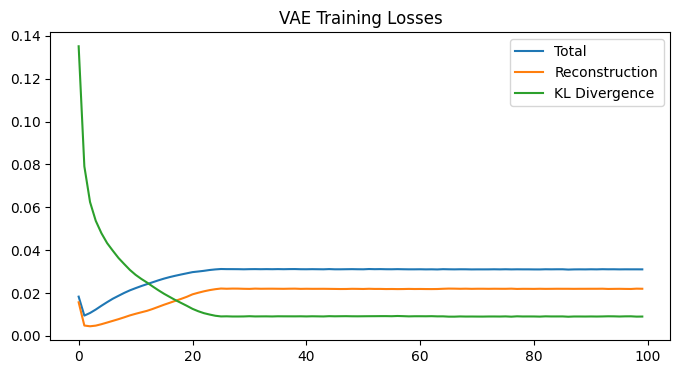

In [9]:
# Plot training losses
plt.figure(figsize=(8,4))
plt.plot(history['total'], label='Total')
plt.plot(history['recon'], label='Reconstruction')
plt.plot(history['kl'], label='KL Divergence')
plt.legend()
plt.title("VAE Training Losses")
plt.show()



In [10]:
# check mu and logvar stats on a batch
vae.eval()
with torch.no_grad():
    sample_batch = torch.tensor(X_train[:512], dtype=torch.float32).to(device)
    mu, logvar = vae.encode(sample_batch)
    print("mu mean/std:", mu.mean().item(), mu.std().item())
    print("logvar mean:", logvar.mean().item(), "logvar std:", logvar.std().item())

mu mean/std: 0.0008849154110066593 0.1035531610250473
logvar mean: -0.01890677586197853 logvar std: 0.15547457337379456


In [11]:
recon, mu, logvar = vae(sample_batch)
mse = ((recon - sample_batch)**2).mean().item()
print("batch recon mse:", mse)


batch recon mse: 0.021609008312225342


In [12]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, entropy, wasserstein_distance
from sklearn.preprocessing import MinMaxScaler
import torch
import os

# ===== 1. Scaler'ı sadece SELECTED_FEATURES üzerinde fit et =====
print("Refitting scaler on non-negative real data...")

clean_df = df_sel.copy()[SELECTED_FEATURES]   # sadece bu 10 kolonu al
clean_df = clean_df[clean_df >= 0].fillna(0)

scaler = MinMaxScaler()
scaler.fit(clean_df)

Refitting scaler on non-negative real data...


MinMaxScaler()

In [13]:
# ===== 2. Güvenli sample fonksiyonu =====
vae.eval()
def sample_synthetic_vae_safe(n_samples=1000):
    with torch.no_grad():
        z = torch.randn(n_samples, LATENT_DIM).to(device)
        decoded = vae.decode(z).cpu().numpy()

        # Clamp: modelin çıkışını 0–1 aralığına sıkıştır
        decoded = np.clip(decoded, 0, 1)

        # Ölçek geri dönüşümü (fit edilen 10 özellik ile aynı boyutta)
        syn = scaler.inverse_transform(decoded)

        # Mantıksız negatifleri sıfırla (özellikle bu kolonlarda)
        for col in ["pktperflow", "byteperflow", "pktrate"]:
            if col in SELECTED_FEATURES:
                idx = SELECTED_FEATURES.index(col)
                syn[:, idx] = np.where(syn[:, idx] < 0, 0, syn[:, idx])

        return syn

In [15]:
# ===== 3. 5000 örnek üret =====
synthetic_data = sample_synthetic_vae_safe(5000)
syn_df = pd.DataFrame(synthetic_data, columns=SELECTED_FEATURES)
print("Generated synthetic samples:", syn_df.shape)
print(syn_df.head(10))

# ===== 4. İstatistiksel benzerlik metrikleri =====
print("\nCalculating distribution similarity metrics...\n")
metrics = []
for col in SELECTED_FEATURES:
    real_col = clean_df[col].values
    syn_col = syn_df[col].values

    # KS test
    ks_stat, ks_p = ks_2samp(real_col, syn_col)

    # KL divergence (histogram bazlı)
    p_hist, _ = np.histogram(real_col, bins=50, density=True)
    q_hist, _ = np.histogram(syn_col, bins=50, density=True)
    kl_div = entropy(p_hist + 1e-8, q_hist + 1e-8)

    # Wasserstein distance
    w_dist = wasserstein_distance(real_col, syn_col)

    metrics.append((col, ks_stat, ks_p, kl_div, w_dist))

metrics_df = pd.DataFrame(metrics, columns=["Feature", "KS_stat", "KS_p", "KL_divergence", "Wasserstein_distance"])
metrics_df = metrics_df.sort_values(by="KS_stat", ascending=False).reset_index(drop=True)
print(metrics_df)

Generated synthetic samples: (5000, 10)
             dt       pktcount     bytecount         dur       tot_dur  \
0  30266.849609   24510.496094  4.186452e+06  433.660828  4.342575e+11   
1  12163.741211   56071.507812  3.634295e+07  238.113968  2.396751e+11   
2  31285.332031   22362.794922  3.569561e+06  465.276550  4.655675e+11   
3  25377.314453   30571.609375  7.522638e+06  356.438019  3.569263e+11   
4  10917.166016   88409.726562  8.359950e+07  267.250275  2.682067e+11   
5  11438.542969   67033.203125  5.240946e+07  240.697357  2.408233e+11   
6  16971.500000   38492.007812  1.464101e+07  268.123199  2.685809e+11   
7  16395.884766   38795.441406  1.514083e+07  263.216156  2.636906e+11   
8  11248.719727  108381.843750  1.078868e+08  299.963409  3.005257e+11   
9  10855.107422   86569.140625  8.047123e+07  258.246704  2.587719e+11   

     packetins    pktperflow  byteperflow     pktrate     tx_bytes  
0  5166.452637  17090.009766   13610846.0  569.155151  111213288.0  
1  5536

In [16]:
# ===== 5. Sonuç CSV kaydet =====
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
SYNTHETIC_PATH = os.path.join(MODEL_DIR, "synthetic_vae_ddos_clean.csv")
syn_df.to_csv(SYNTHETIC_PATH, index=False)
print(f"\n✅ Cleaned synthetic CSV saved: {SYNTHETIC_PATH}")

# ===== 6. Ek bilgi: özet istatistik kontrolü =====
print("\nSynthetic summary stats:\n", syn_df.describe().T)


✅ Cleaned synthetic CSV saved: models/synthetic_vae_ddos_clean.csv

Synthetic summary stats:
               count          mean           std           min           25%  \
dt           5000.0  1.779232e+04  6.960795e+03  1.041187e+04  1.173975e+04   
pktcount     5000.0  5.608776e+04  3.054328e+04  1.065205e+04  3.292850e+04   
bytecount    5000.0  3.989001e+07  3.919928e+07  2.259960e+06  9.164825e+06   
dur          5000.0  3.249426e+02  1.324884e+02  2.180187e+02  2.463810e+02   
tot_dur      5000.0  3.255365e+11  1.324716e+11  2.181805e+11  2.469699e+11   
packetins    5000.0  5.322463e+03  6.055044e+02  2.445544e+03  4.879185e+03   
pktperflow   5000.0  1.753417e+04  3.374166e+02  1.673117e+04  1.724896e+04   
byteperflow  5000.0  1.398762e+07  3.245953e+05  1.347204e+07  1.368757e+07   
pktrate      5000.0  5.839730e+02  1.120755e+01  5.574028e+02  5.744781e+02   
tx_bytes     5000.0  9.411979e+07  1.432311e+07  7.208327e+07  8.339033e+07   

                      50%          

In [17]:
# ===== FIXED: TSTR (Train on Synthetic, Test on Real) with pseudo-labeling =====
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Ensure we have y and split real data properly ---
# df_sel ve SELECTED_FEATURES zaten notebook'ta tanımlı olmalı
# X_scaled was created earlier; rebuild split with labels
X = df_sel[SELECTED_FEATURES].astype(float).values
y = df_sel[TARGET_COL].astype(int).values  # shape (N,)

# Split features+labels into train/val (real) so we have X_val,y_val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)
print("Real train shape:", X_train.shape, "Real val shape:", X_val.shape)

Real train shape: (93910, 10) Real val shape: (10435, 10)


In [18]:
# --- 2) If synthetic has no labels, create pseudo-labels using a classifier trained on REAL data ---
# Train a classifier on real training data
clf_real = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_real.fit(X_train, y_train)
print("Trained pseudo-labeler on real data.")

# Predict labels for synthetic data (pseudo-labeling)
X_synth = syn_df[SELECTED_FEATURES].values  # syn_df was created earlier (clean synthetic)
y_synth_pseudo = clf_real.predict(X_synth)
print("Assigned pseudo-labels to synthetic data. Distribution:", np.bincount(y_synth_pseudo))

# Build synthetic-labeled dataframe (for clarity)
syn_labeled_df = syn_df.copy()
syn_labeled_df[TARGET_COL] = y_synth_pseudo

Trained pseudo-labeler on real data.
Assigned pseudo-labels to synthetic data. Distribution: [2593 2407]



=== TSTR (Train on Synthetic w/ pseudo-labels -> Test on Real) ===
Accuracy on real validation set: 0.5886
F1-score (weighted): 0.5546

Classification report (real val):
              precision    recall  f1-score   support

           0     1.0000    0.3246    0.4901      6356
           1     0.4872    1.0000    0.6552      4079

    accuracy                         0.5886     10435
   macro avg     0.7436    0.6623    0.5726     10435
weighted avg     0.7996    0.5886    0.5546     10435



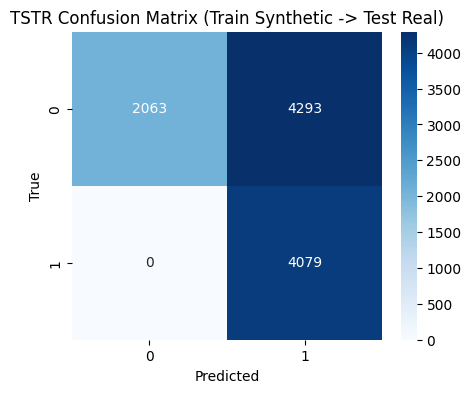

In [19]:
# --- 3) TSTR: Train classifier on synthetic (pseudo-labeled), test on held-out real val set ---
clf_tstr = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_tstr.fit(X_synth, y_synth_pseudo)
y_pred_on_real = clf_tstr.predict(X_val)

acc_tstr = accuracy_score(y_val, y_pred_on_real)
f1_tstr = f1_score(y_val, y_pred_on_real, average='weighted')

print("\n=== TSTR (Train on Synthetic w/ pseudo-labels -> Test on Real) ===")
print(f"Accuracy on real validation set: {acc_tstr:.4f}")
print(f"F1-score (weighted): {f1_tstr:.4f}")
print("\nClassification report (real val):")
print(classification_report(y_val, y_pred_on_real, digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_val, y_pred_on_real)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('TSTR Confusion Matrix (Train Synthetic -> Test Real)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

In [20]:
# --- 4) Optional: two-sample separability (how well can a classifier separate real vs synthetic) ---
# Build combined dataset: real (label 1) vs synthetic (label 0)
real_marker = np.ones(len(X_val), dtype=int)  # use validation real subset
synth_marker = np.zeros(len(X_synth), dtype=int)

X_comb = np.vstack([X_val, X_synth])
y_comb = np.concatenate([real_marker, synth_marker])

clf_two_sample = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_two_sample.fit(X_comb, y_comb)
yhat = clf_two_sample.predict(X_comb)
acc_two_sample = accuracy_score(y_comb, yhat)
print(f"\nClassifier two-sample accuracy (real vs synthetic separability): {acc_two_sample:.4f}")
print("Lower is better (0.5 means indistinguishable).")


Classifier two-sample accuracy (real vs synthetic separability): 1.0000
Lower is better (0.5 means indistinguishable).
